<a href="https://colab.research.google.com/github/MACHARODRIGO/tRNASec-Study-Project/blob/main/notebooks/tRNA_ml_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖥️🧬 tRNA Machine Learning Exploration  

### 🎯 Objective  
This notebook explores how **basic sequence-derived features** can be used to classify **tRNAs** by their domain of life (**🧑‍🔬 Eukarya vs 🧫 Bacteria**).  

---

### ✅ Goals  
- 📂 Parse a **multifasta** file of tRNA sequences and link them to their species and domains.  
- 🔎 Extract simple **sequence features**:  
  - 🧬 Nucleotide composition (**%A, %U, %G, %C**)  
  - 🧩 Motif presence (**anticodon UCA**, **codon UGA**)  
  - 🔡 k-mer frequencies (**2-mers**)  
  - 📏 Sequence length  
- 🖥️ Train baseline **ML classifiers**: 🌳 Decision Tree, 🌲 Random Forest, 🌀 SVM.  
- 📊 Evaluate models with:  
  - 🔄 Cross-validation  
  - 🧾 Test set metrics  
  - ⭐ Feature importance  
  - 📈 Learning curves  

---

### ⚠️ Limitations  
- Current feature set is **simplistic** (composition + motifs), without:  
  - 🏗️ Structural descriptors  
  - 🧪 Modification data  
- Predictions are restricted to a **binary classification**: 🧫 Bacteria vs 🧑‍🔬 Eukarya.  
- Goal = **prototype an ML workflow** 🖥️🧬 rather than biological novelty.

---
## 🟢 Step 0. Environment Setup
In this step we:
1. Installing required libraries.  
2. Importing all packages used in this notebook.  
3. Downloading input files (FASTA and CSV) directly from Google Drive.  
4. Activating helper functions for parsing, merging, and feature extraction.  

In [3]:
#@title Step 0: Install dependencies, import libraries, and load functions { display-mode: "form" }

# --- 1. Install required packages ---

!pip install biopython gdown

# --- 2. Import libraries ---

import gdown
from Bio import SeqIO
import pandas as pd
import numpy as np
from itertools import product
import requests
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product
from IPython.display import display, Markdown

# --- 4. Activate utility functions (parsing, merging, feature extraction) ---

# ----------------------------
# 1. Parse FASTA with species info
# ----------------------------
def parse_fasta_with_species(fasta_file):
    records = []
    for rec in SeqIO.parse(fasta_file, "fasta"):
        desc = rec.description
        seq = str(rec.seq).upper().replace("T", "U")

        # Clean ID (only URSxxxxx)
        clean_id = desc.split("|")[0]   # everything before the first "|"

        # Species: take the second part after "|", replace spaces with "_"
        try:
            species = desc.split("|")[1].replace(" ", "_")
        except IndexError:
            species = "Unknown"

        records.append({
            "id": clean_id,
            "species": species,
            "sequence": seq
        })
    return pd.DataFrame(records)

# ----------------------------
# 2. Merge with domain CSV
# ----------------------------
def merge_with_domain(fasta_df, csv_file):
    domain_df = pd.read_csv(csv_file)

    # Ensure consistency of species column name
    if "Species" in domain_df.columns:
        species_col = "Species"
    elif "species" in domain_df.columns:
        species_col = "species"
    elif "Organism" in domain_df.columns:
        species_col = "Organism"
    else:
        raise ValueError(f"⚠️ Species column not found in CSV. Available columns: {domain_df.columns}")

    # Normalize names
    domain_df["species"] = domain_df[species_col].str.replace(" ", "_")
    domain_df["domain"] = domain_df["domain"]
    merged = fasta_df.merge(domain_df, on="species", how="left")
    return merged

# ----------------------------
# 3. Extract additional features
# ----------------------------
def extract_seq_features(df, k=2):
    kmers = ["".join(p) for p in product("AUGC", repeat=k)]
    feature_rows = []

    for _, row in df.iterrows():
        seq = row["sequence"]
        length = len(seq)

        perc = {nt: seq.count(nt)/length for nt in "AUGC"}
        counts = {kmer: seq.count(kmer)/(length-k+1) for kmer in kmers}

        has_UCA = 1 if "UCA" in seq else 0
        has_UGA = 1 if "UGA" in seq else 0

        feat = {
            "id": row["id"],
            "species": row["species"],
            "domain": row["domain"],  # comes from CSV
            "length": length,
            **perc,
            **counts,
            "has_UCA": has_UCA,
            "has_UGA": has_UGA
        }
        feature_rows.append(feat)

    return pd.DataFrame(feature_rows)

# ----------------------------
# 4. Complete pipeline
# ----------------------------
def build_feature_table(fasta_file, csv_file, k=2):
    fasta_df = parse_fasta_with_species(fasta_file)
    merged_df = merge_with_domain(fasta_df, csv_file)
    feature_df = extract_seq_features(merged_df, k=k)
    return feature_df

# --- 3. Download input files from Google Drive ---

# FASTA (sequence data)
file_id = "14sQs3vaVxI8f5pWaxVZzlBVudj8tXKbY"
url = f"https://drive.google.com/uc?id={file_id}"
fasta_file = gdown.download(url, "sequences.fasta", quiet=False)

# CSV (features data)
csv_file_id = "1VLxpNfkPrd1-tbtx6tqu8BDwXDa1oljW"
csv_url = f"https://drive.google.com/uc?id={csv_file_id}"
feature_file = gdown.download(csv_url, "features.csv", quiet=False)

# Step 1: Build the complete feature table
final_df = build_feature_table(fasta_file, feature_file, k=2)

# Step 2: Inspect the first rows
print(final_df.head())

# Step 3: Save the final table for Machine Learning
final_df.to_csv("tRNA_features_final.csv", index=False)

display(Markdown("📦 All dependencies installed, data files retrieved, and helper functions activated. Ready to go!"))

Downloading...
From: https://drive.google.com/uc?id=14sQs3vaVxI8f5pWaxVZzlBVudj8tXKbY
To: /content/sequences.fasta
100%|██████████| 72.9k/72.9k [00:00<00:00, 6.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VLxpNfkPrd1-tbtx6tqu8BDwXDa1oljW
To: /content/features.csv
100%|██████████| 1.28k/1.28k [00:00<00:00, 4.97MB/s]

                   id       species domain  length         A         U  \
0  URS00001DA281_9606  Homo_sapiens      E      87  0.172414  0.252874   
1  URS0000C8E9EB_9606  Homo_sapiens      E      84  0.190476  0.297619   
2  URS00008FED48_9606  Homo_sapiens      E      90  0.177778  0.244444   
3  URS000014E598_9606      Sec_from    NaN      90  0.177778  0.244444   
4  URS00006501FF_9606  Homo_sapiens      E      87  0.183908  0.287356   

          G         C        AA        AU  ...        GA        GU        GG  \
0  0.310345  0.264368  0.023256  0.034884  ...  0.046512  0.081395  0.081395   
1  0.285714  0.226190  0.024096  0.036145  ...  0.048193  0.108434  0.072289   
2  0.311111  0.266667  0.022472  0.033708  ...  0.044944  0.078652  0.089888   
3  0.300000  0.277778  0.022472  0.033708  ...  0.044944  0.078652  0.078652   
4  0.298851  0.229885  0.023256  0.034884  ...  0.046512  0.104651  0.081395   

         GC        CA        CU        CG        CC  has_UCA  has_UGA  
0 

📦 All dependencies installed, data files retrieved, and helper functions activated. Ready to go!

#

# ⚙️ Machine Learning Pipeline for tRNA

## Step 1 - Prepare Dataset

In [4]:
# Drop rows with missing labels
df = final_df.dropna(subset=["domain"])
df = df[df["domain"].isin(["E", "B"])]

# Features (numeric only)
X = df.drop(columns=["id", "species", "domain"])
y = df["domain"]

print("\nFeature matrix shape:", X.shape)
print("Target vector distribution:\n", y.value_counts())


Feature matrix shape: (118, 23)
Target vector distribution:
 domain
B    81
E    37
Name: count, dtype: int64


## Step 2 : Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 94
Test set size: 24


## Step 3:  Train models

### Decision Tree

In [6]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
print("Decision Tree Accuracy:", tree_clf.score(X_test, y_test))


Decision Tree Accuracy: 1.0


Random Forest

In [7]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)
print("Random Forest Accuracy:", rf_clf.score(X_test, y_test))

Random Forest Accuracy: 1.0


Support Vector Machine

In [8]:
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
svm_clf.fit(X_train, y_train)
print("SVM Accuracy:", svm_clf.score(X_test, y_test))


SVM Accuracy: 1.0


## Step 4 : Cross-validation


In [9]:
print("\nStep 4: Cross-validation (all models, cv=5)...")

for name, model in [
    ("Decision Tree", tree_clf),
    ("Random Forest", rf_clf),
    ("SVM", svm_clf),
]:
    scores = cross_val_score(model, X, y, cv=5)
    print(f"{name} CV scores:", scores)
    print(f"{name} Mean CV Accuracy: {np.mean(scores):.3f}\n")


Step 4: Cross-validation (all models, cv=5)...
Decision Tree CV scores: [0.91666667 0.875      1.         0.82608696 1.        ]
Decision Tree Mean CV Accuracy: 0.924

Random Forest CV scores: [1.    0.875 1.    1.    1.   ]
Random Forest Mean CV Accuracy: 0.975

SVM CV scores: [0.95833333 0.875      1.         1.         1.        ]
SVM Mean CV Accuracy: 0.967



### 📊 Interpretation of Results  

- 🌳 **Decision Tree** → simpler, interpretable, ~92% accuracy.  
- 🌲 **Random Forest** → very robust, ~97.5% accuracy.  
- 🌀 **SVM** → strong generalization, ~96.7% accuracy.  
- ✅ All three achieve **>90% accuracy** separating bacterial from eukaryotic tRNAs.  

## Step 5: Final Evaluation on Test Set

After cross-validation, we evaluate all models on the independent **test set**.  
We report the **classification report** (precision, recall, F1-score) and the **confusion matrix**.


In [10]:
for name, model in [
    ("Decision Tree", tree_clf),
    ("Random Forest", rf_clf),
    ("SVM", svm_clf),
]:
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")


=== Decision Tree ===

Classification Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        16
           E       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:

=== Random Forest ===

Classification Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        16
           E       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:

=== SVM ===

Classification Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        16
           E       1.00      1.00      1.00         8

    accuracy   

### 📊 Interpretation of Results  

- ✅ All models (🌳 Decision Tree, 🌲 Random Forest, 🌀 SVM) achieved **perfect classification** (100% accuracy).  
- 📊 No misclassifications: all 16 Bacterial tRNAs → B, all 8 Eukaryotic tRNAs → E.  
- ⚠️ While this validates the ML pipeline, it also shows the dataset is **easily separable** and highlights the need for more complex features (structure, modifications) for deeper biological insights.  

## Step 6: Feature Importance (Tree-based Models Only)

For tree-based models we can measure feature importance, i.e.
which features (k-mers, sequence properties) contribute most to the classification.

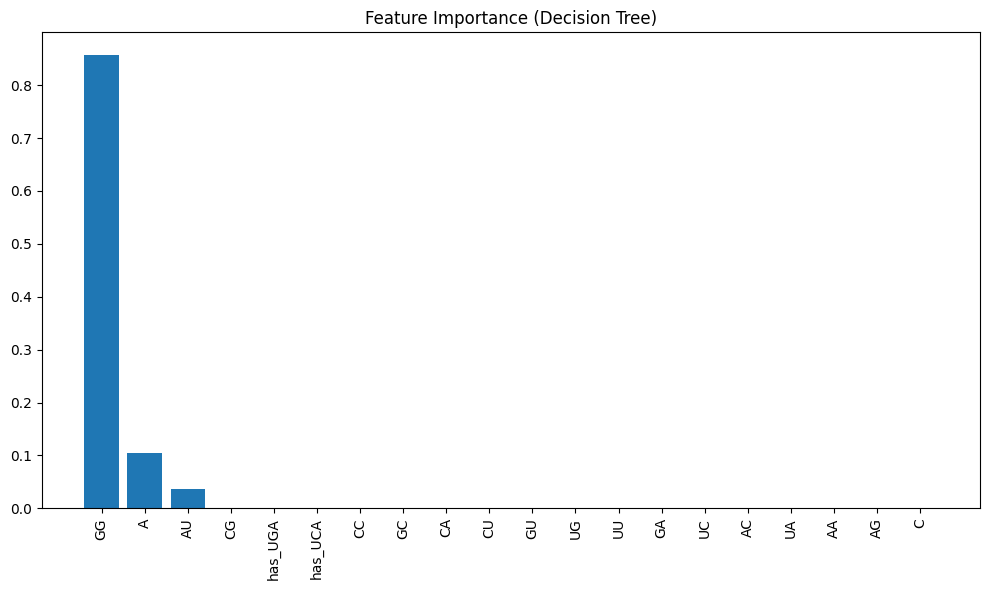

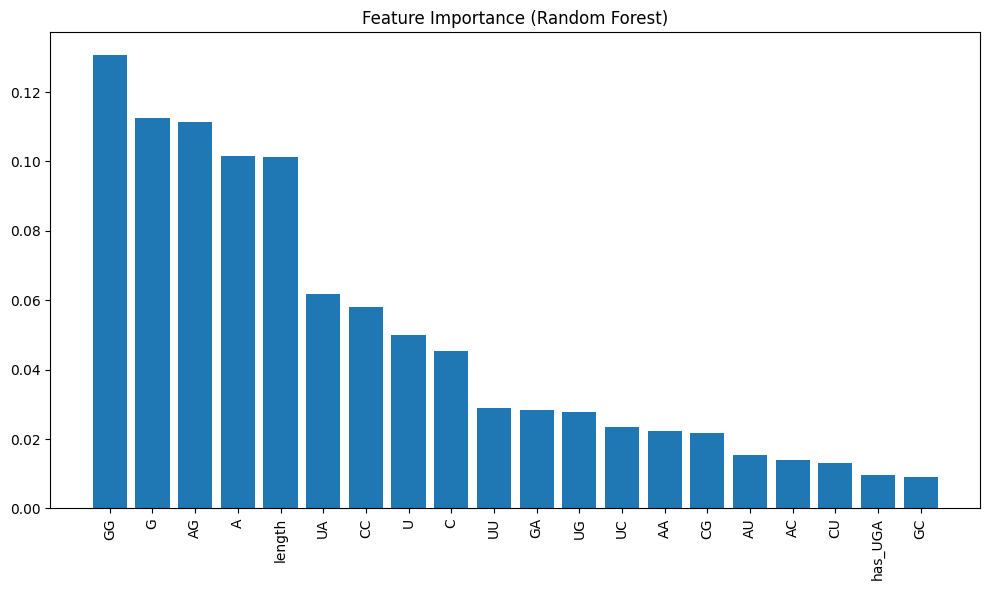

In [11]:
for name, model in [
    ("Decision Tree", tree_clf),
    ("Random Forest", rf_clf),
]:
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,6))
    plt.title(f"Feature Importance ({name})")
    plt.bar(range(20), importances[indices[:20]], align="center")
    plt.xticks(range(20), X.columns[indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()


### 📊 Interpretation of Results  

- The **“GG” di-nucleotide frequency** 🧬 dominated classification.  
- Secondary contributors: %A and AU frequency.  
- This shows the model relies on **low-level compositional bias** rather than biological structure → effective but oversimplified.  


## Step 7: Learning Curves (Accuracy Tables)

To analyze how performance changes with training set size,  
we compute learning curves for each model and export them as “accuracy tables”.



Decision Tree Accuracy Table:
    train_size  train_accuracy  val_accuracy          model
0           9             1.0      0.396739  Decision Tree
1          30             1.0      0.682246  Decision Tree
2          51             1.0      0.712681  Decision Tree
3          72             1.0      0.923551  Decision Tree
4          94             1.0      0.923551  Decision Tree


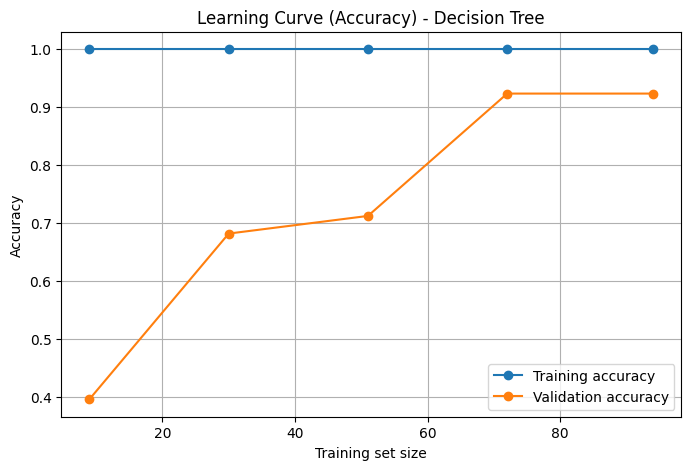


Random Forest Accuracy Table:
    train_size  train_accuracy  val_accuracy          model
0           9             1.0      0.430072  Random Forest
1          30             1.0      0.659783  Random Forest
2          51             1.0      0.905797  Random Forest
3          72             1.0      0.975000  Random Forest
4          94             1.0      0.975000  Random Forest


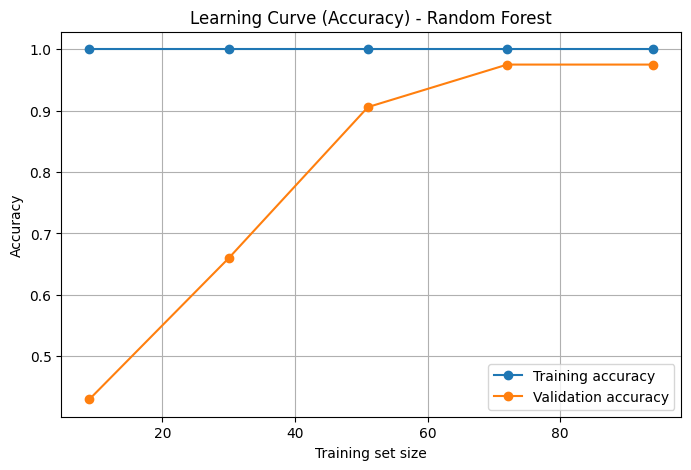


SVM Accuracy Table:
    train_size  train_accuracy  val_accuracy model
0           9             NaN           NaN   SVM
1          30             1.0      0.658333   SVM
2          51             1.0      0.880435   SVM
3          72             1.0      0.905797   SVM
4          94             1.0      0.966667   SVM


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last

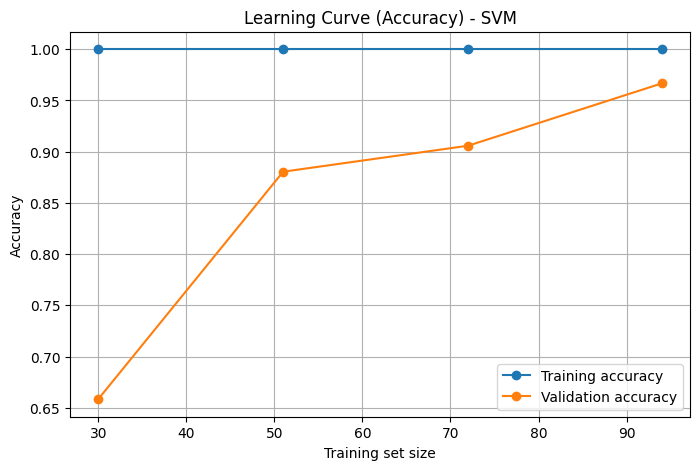

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

accuracy_tables = []

for name, model in [
    ("Decision Tree", tree_clf),
    ("Random Forest", rf_clf),
    ("SVM", svm_clf),
]:
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    acc_table = pd.DataFrame({
        "train_size": train_sizes,
        "train_accuracy": train_mean,
        "val_accuracy": test_mean,
        "model": name
    })
    print(f"\n{name} Accuracy Table:\n", acc_table)
    accuracy_tables.append(acc_table)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training accuracy")
    plt.plot(train_sizes, test_mean, "o-", label="Validation accuracy")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve (Accuracy) - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

all_accuracy_df = pd.concat(accuracy_tables)
all_accuracy_df.to_csv("accuracy_tables.csv", index=False)

## Step 8: Learning Curves (Loss Tables)

To analyze how performance changes with training set size,  
we compute learning curves for each model and export them as “loss tables”.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   


Decision Tree Loss Table:
    train_size    train_loss   val_loss          model
0           9           NaN        NaN  Decision Tree
1          30  2.220446e-16  11.453001  Decision Tree
2          51  2.220446e-16  10.356021  Decision Tree
3          72  2.220446e-16   2.755511  Decision Tree
4          94  2.220446e-16   2.755511  Decision Tree


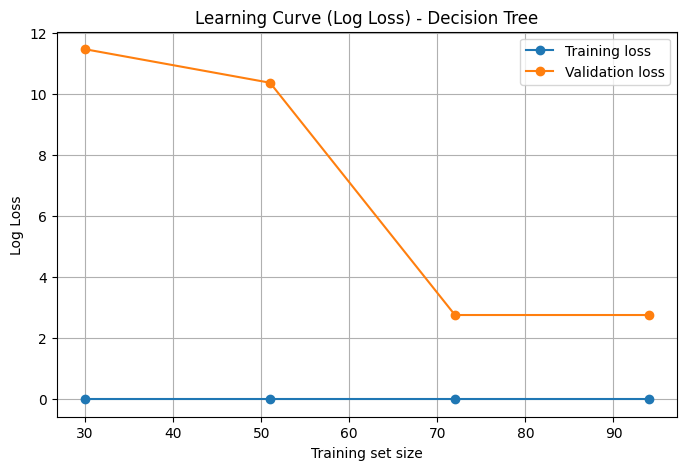

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   


Random Forest Loss Table:
    train_size  train_loss  val_loss          model
0           9         NaN       NaN  Random Forest
1          30    0.024554  0.604957  Random Forest
2          51    0.036419  0.262692  Random Forest
3          72    0.025614  0.145487  Random Forest
4          94    0.018962  0.125515  Random Forest


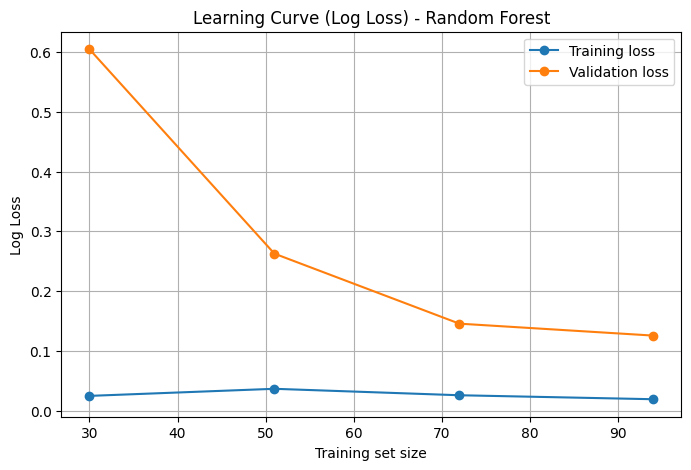

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F


SVM Loss Table:
    train_size  train_loss  val_loss model
0           9         NaN       NaN   SVM
1          30         NaN       NaN   SVM
2          51         NaN       NaN   SVM
3          72         NaN       NaN   SVM
4          94         NaN       NaN   SVM


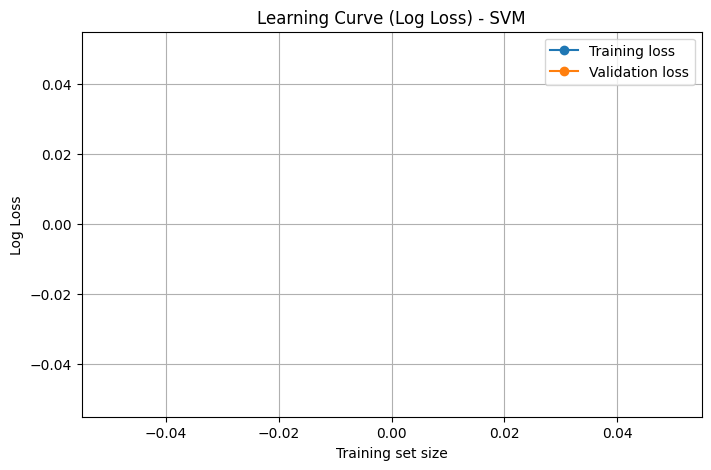

In [13]:
loss_tables = []

for name, model in [
    ("Decision Tree", tree_clf),
    ("Random Forest", rf_clf),
    ("SVM", svm_clf),
]:
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="neg_log_loss",
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    # sklearn devuelve loss negativo → lo multiplicamos por -1
    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    loss_table = pd.DataFrame({
        "train_size": train_sizes,
        "train_loss": train_mean,
        "val_loss": test_mean,
        "model": name
    })
    print(f"\n{name} Loss Table:\n", loss_table)
    loss_tables.append(loss_table)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training loss")
    plt.plot(train_sizes, test_mean, "o-", label="Validation loss")
    plt.xlabel("Training set size")
    plt.ylabel("Log Loss")
    plt.title(f"Learning Curve (Log Loss) - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

all_loss_df = pd.concat(loss_tables)
all_loss_df.to_csv("loss_tables.csv", index=False)


### 📊 Interpretation of Results

- 🏆 **Training accuracy = 1.0** for all models (they memorize training data).  
- Validation accuracy improves with more samples:  
  - 🌳 Decision Tree → up to ~0.92  
  - 🌲 Random Forest → up to ~0.97  
  - 🌀 SVM → up to ~0.97  
- ⚖️ Curves show high variance with small datasets, then stabilize.  
- ⚠️ SVM produced a warning (class imbalance during CV) → not model error but dataset artifact.  


## 🏁 Conclusion  
With only **basic sequence-derived features** 🧬, classical ML models 🖥️ can already distinguish 🧑‍🔬 Eukaryotic vs 🧫 Bacterial tRNAs with very high accuracy.  

But:  
- The approach is **oversimplified** 🪶, dominated by compositional bias (GG content).  
- Biological interpretability = limited 🤔.  
- To gain insights, we need to add richer features:  
  - 🏗️ **Structural descriptors** (stems, loops, pairing fraction).  
  - 🧪 **Modification presence/absence** (Ψ55, m¹A58, etc.).  
  - 🌐 **Evolutionary / clustering signals** across domains.  

👉 This notebook serves as a **proof-of-concept** prototype: parsing → feature extraction → ML → evaluation ✅.  
Next step = evolve toward **biologically meaningful insights** by integrating **structure** and **epitranscriptomic modifications**.  